# Example usage

So, you've generated your design and run your experiements. Now comes the hard part of building the model. So to use `doenut` in a project you will need some data to fit. We label these `inputs` and `responses`. First, let's load the packages and set the logging level to something appropriate.

In [42]:
import doenut
import pandas as pd
import matplotlib.pyplot as plt

doenut.set_log_level("WARNING")

Now load the responses into dataframes. In this case, we've already split the data into two csv files so it is nice and straightforward.

In [19]:
inputs = pd.read_csv("data/inputs.csv")
responses = pd.read_csv("data/responses.csv")["Profit"]

In [20]:
inputs

,P,Temp.,Flow,Purge,Cool
0,200.0,300.0,10800.0,0.0,-150.0
1,950.0,300.0,10800.0,0.0,-30.0
2,200.0,600.0,10800.0,0.0,-30.0
3,950.0,600.0,10800.0,0.0,-150.0
4,200.0,300.0,16800.0,0.0,-30.0
5,950.0,300.0,16800.0,0.0,-150.0
6,200.0,600.0,16800.0,0.0,-150.0
7,950.0,600.0,16800.0,0.0,-30.0
8,200.0,300.0,10800.0,25.0,-150.0
9,950.0,300.0,10800.0,25.0,-30.0


In [21]:
responses

0     10901.0
1    -12000.0
2     -5222.0
3     22675.0
4    -12000.0
5     54224.0
6     -3558.0
7     -6188.0
8      5264.0
9    -12000.0
10    -6395.0
11    14140.0
12   -12000.0
13    37206.0
14    -5727.0
15    -7225.0
16    25032.0
Name: Profit, dtype: float64

First, let's create a fully populated model and see how good that is (or isn't).

In [27]:
dataset = doenut.data.ModifiableDataSet(inputs, responses)
(
    basic_scaled_model,
    basic_unscaled_model,
) = doenut.models.AveragedModel.tune_model(dataset)
print(
    f"Model results: R2 {round(basic_scaled_model.r2, 2)}, Q2 {round(basic_scaled_model.q2, 2)}"
)

INFO - Running Tune Model
INFO - Constructing AveragedModel
INFO - Applying <class 'doenut.data.modifiers.ortho_scaler.OrthoScaler'> to dataset
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset
INFO - Q2 is 0.178
INFO - Constructed AveragedModel
INFO - Constructing AveragedModel
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset
INFO - Q2 is 0.178
INFO - Constructed AveragedModel


Model results: R2 0.64, Q2 0.18


Well, the R2 is OK, but that is not a good Q2. Let's try a saturated model. First we need to generate the dataset and build fresh models.

In [31]:
saturated_inputs, saturated_source_list = doenut.add_higher_order_terms(inputs)
saturated_columns = list(saturated_inputs.columns)
print(saturated_columns)
saturated_dataset = doenut.data.ModifiableDataSet(saturated_inputs, responses)
(
    saturated_scaled_model,
    saturated_unscaled_model,
) = doenut.models.AveragedModel.tune_model(saturated_dataset)
print(
    f"Model results: R2 {round(saturated_scaled_model.r2, 2)}, Q2 {round(saturated_scaled_model.q2, 2)}"
)

INFO - Running Tune Model
INFO - Constructing AveragedModel
INFO - Applying <class 'doenut.data.modifiers.ortho_scaler.OrthoScaler'> to dataset
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset


['P', 'Temp.', 'Flow', 'Purge', 'Cool', 'P**2', 'Temp.**2', 'Flow**2', 'Purge**2', 'Cool**2', 'P*Temp.', 'P*Flow', 'P*Purge', 'P*Cool', 'Temp.*Flow', 'Temp.*Purge', 'Temp.*Cool', 'Flow*Purge', 'Flow*Cool', 'Purge*Cool']


INFO - Q2 is 0.758
INFO - Constructed AveragedModel
INFO - Constructing AveragedModel
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset
INFO - Q2 is 0.793
INFO - Constructed AveragedModel


Model results: R2 0.99, Q2 0.76


Note that off the bat that is significantly better, but we can still improve. Let's plot the coefficents to see if any are insignificant. Note that this is what we use the *scaled* model for - it allows us to compare the coefficients directly.

Input_selector was: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Average coefficients are: [  1.25306962   7.11379047   2.11312542   3.82547541  -6.78594611
  -5.01631432  -2.27660597  -4.1607204   -3.69115095  -2.50497266
   0.36882115  11.07279902  -2.32877925 -16.79564447  -1.19514006
   1.28809486   7.06118971  -0.64517142  -6.8157383    4.11896796]
Errors are [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['P', 'Temp.', 'Flow', 'Purge', 'Cool', 'P**2', 'Temp.**2', 'Flow**2', 'Purge**2', 'Cool**2', 'P*Temp.', 'P*Flow', 'P*Purge', 'P*Cool', 'Temp.*Flow', 'Temp.*Purge', 'Temp.*Cool', 'Flow*Purge', 'Flow*Cool', 'Purge*Cool']


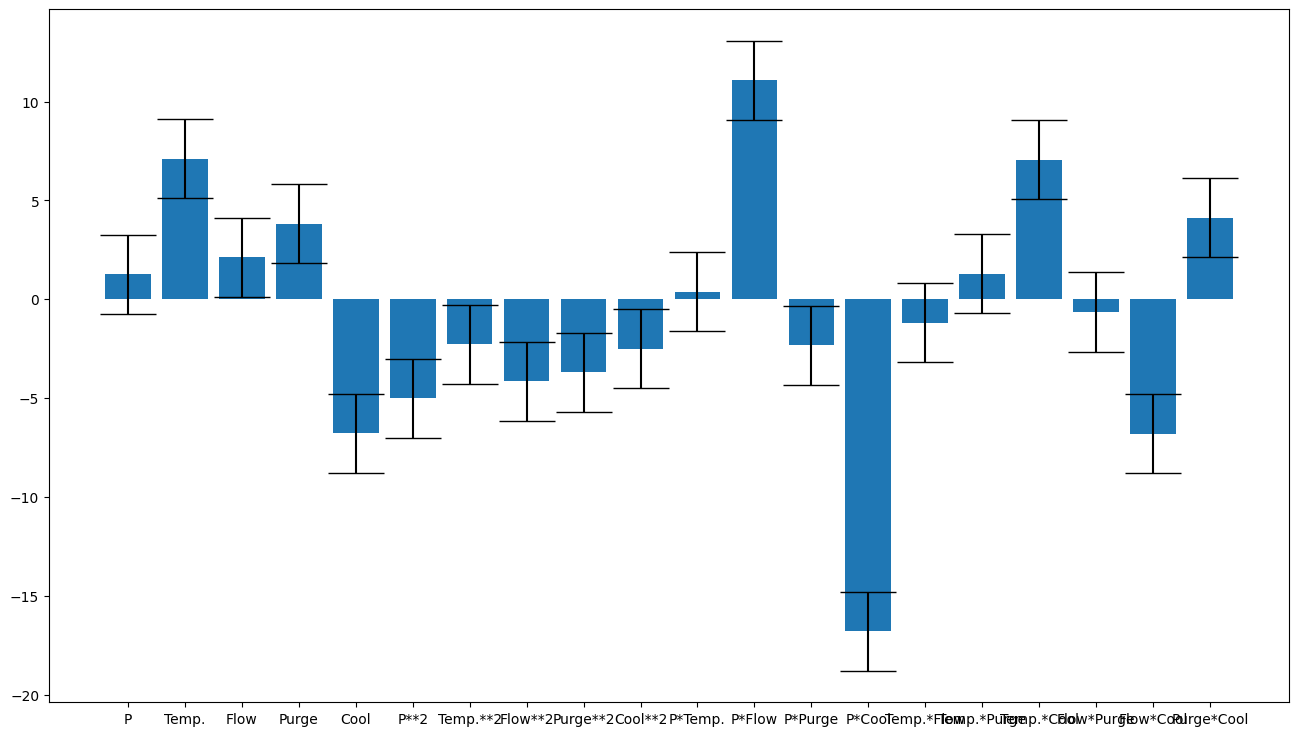

In [32]:
doenut.plot.coeff_plot(
    saturated_scaled_model.coeffs,
    labels=saturated_columns,
    errors="p95",
    normalise=True,
)

Let's remove the term `P*Temp`. To do this, make a list of the columns you want (either names *or* by column index) and create a filtered version of the dataset

INFO - Applying <class 'doenut.data.modifiers.column_selector.ColumnSelector'> to dataset
INFO - Running Tune Model
INFO - Constructing AveragedModel
INFO - Applying <class 'doenut.data.modifiers.ortho_scaler.OrthoScaler'> to dataset
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset
INFO - Q2 is 0.765
INFO - Constructed AveragedModel
INFO - Constructing AveragedModel
INFO - Setting response_key to responses
INFO - Applying <class 'doenut.data.modifiers.duplicate_remover.DuplicateRemover'> to dataset
INFO - Q2 is 0.799
INFO - Constructed AveragedModel


Input_selector was: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Average coefficients are: [  1.19066062   6.8002752    1.69896309   3.78976886  -4.9481041
  -5.29855244  -2.35390278  -4.42824778  -3.67289423  -2.77328902
   9.43719155  -2.32877925 -16.91237789  -0.81836908   1.28809486
   6.03553243  -0.64517142  -4.0941079    4.11896796]
Errors are [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['P', 'Temp.', 'Flow', 'Purge', 'Cool', 'P**2', 'Temp.**2', 'Flow**2', 'Purge**2', 'Cool**2', 'P*Flow', 'P*Purge', 'P*Cool', 'Temp.*Flow', 'Temp.*Purge', 'Temp.*Cool', 'Flow*Purge', 'Flow*Cool', 'Purge*Cool']
Model results: R2 0.99, Q2 0.77


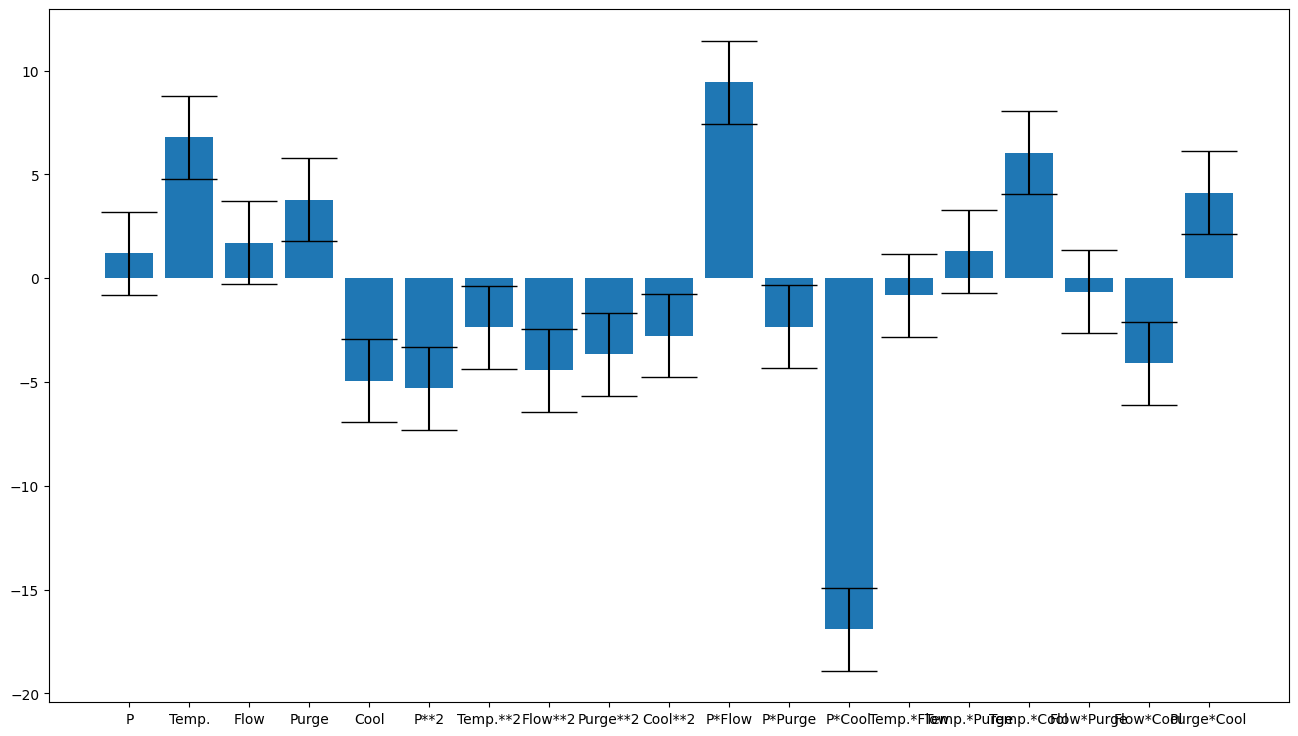

In [39]:
column_selector = [x for x in saturated_columns if x != "P*Temp."]
filtered_dataset = doenut.data.ModifiableDataSet(
    saturated_inputs, responses
).filter(column_selector)
(
    filtered_scaled_model,
    filtered_unscaled_model,
) = doenut.models.AveragedModel.tune_model(filtered_dataset)
doenut.plot.coeff_plot(
    filtered_scaled_model.coeffs,
    labels=column_selector,
    errors="p95",
    normalise=True,
)
print(
    f"Model results: R2 {round(filtered_scaled_model.r2, 2)}, Q2 {round(filtered_scaled_model.q2, 2)}"
)

A slight improvement in Q2 *and* we are using fewer terms (generally a good thing). We can also plot how good the fit looks like this:

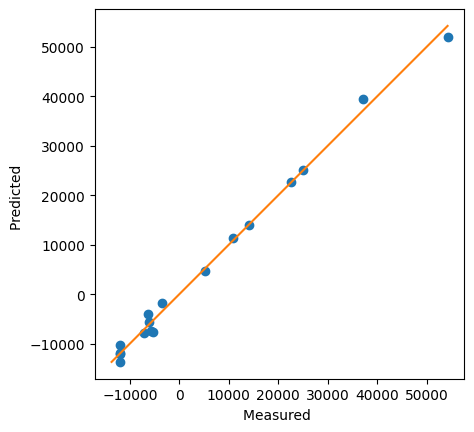

In [41]:
doenut.plot.plot_observed_vs_predicted(
    responses, filtered_unscaled_model.predictions
)

Not bad. Now normally you would continue around the loop a few times, removing terms until you have a nicely parsimonious model, but for the sake of brevity let's pretend this is the best one (it's not bad, but there are certainly better ones (Excercise for the reader: You can get a Q2 of 0.862 with this approach - see if you can find it!).